In [1]:
import importlib.util
import sys
loc = '/afs/ciemat.es/user/m/martialc/public/muTel_v4/muTel/src/muTel/__init__.py'
# loc = r'..\..\..\src\muTel\__init__.py'
src = 'muTel'
spec = importlib.util.spec_from_file_location(src, loc)
foo = importlib.util.module_from_spec(spec)
sys.modules[src] = foo
spec.loader.exec_module(foo)
%load_ext autoreload

In [2]:
from IPython.display import display
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyarrow.parquet as pq
import pyarrow as pa
import os
from timeit import default_timer as timer
from scipy.optimize import curve_fit

import muTel.utils.meta as meta
from muTel.utils.tools import flatten_dict
from muTel.utils.units import Time

from muTel.dqm.classes.MuData import MuData
from muTel.dqm.classes.MuEvent import MuEvent
from muTel.dqm.utils.fitting import *
from muTel.dqm.utils.pattern import lats4patt


-1.2706251559647845 < 0 < 1.2706251559647845
-63.0 < 0 < 735.0
540.8380681818182 < 710 < 922.65625
RLRX
  v_drift:	55.00 um/ns
  t0:     	698.0 ns
  phi:    	0.05π (8.18º)
  x0:     	6.18·width
  chi2:   	0.000



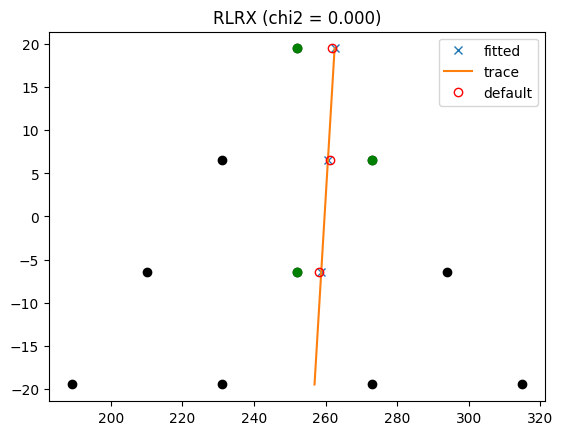

RLLX
  v_drift:	55.00 um/ns
  t0:     	574.8 ns
  phi:    	0.28π (49.86º)
  x0:     	5.86·width
  chi2:   	0.000



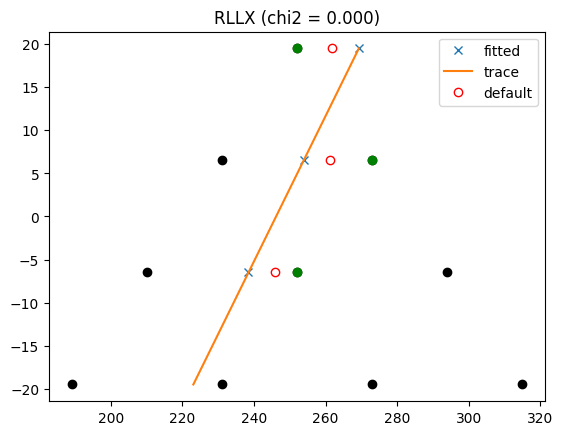

LLRX
  v_drift:	55.00 um/ns
  t0:     	540.8 ns
  phi:    	-0.29π (-53.05º)
  x0:     	6.18·width
  chi2:   	0.009



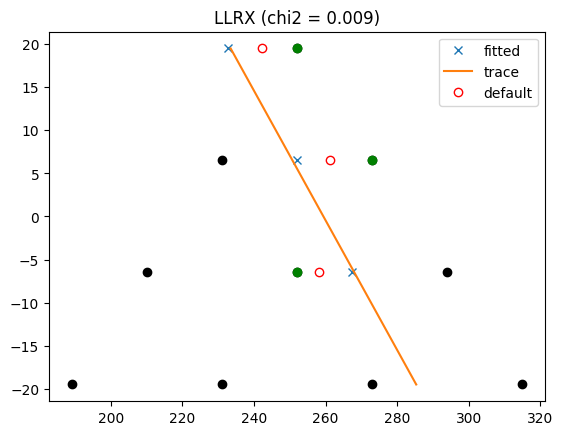

In [5]:
width       = 42
height      = 13
v           =  55e-3


dt          = np.array([889.0625 , 922.65625, 821.09375,       np.nan])
# dt          = np.array([ 736.71875,  1060.15625,     725.78125,      935.9375    ])
z           = np.array([ 19.5,       6.5,            -6.5,           -19.5       ])
cells       = np.array([ 6,          6,              6,              np.nan          ])
# cells       = np.array([ 6,          6,              6,              6          ])
cell_shift  = np.array([ 0.,         0.5,            0.,             0.5         ])
xn          = (cells + cell_shift)*width
xn_0        = xn[~np.isnan(xn)][0]


p0          = [0, 0, 710]
bounds      = [
                [-np.arctan(width/height), -1.5 *width, np.nanmax(dt)-width/2/v],
                [ np.arctan(width/height),  17.5*width, np.nanmax(dt)],
            ]

lat_id_list = lats4patt('RLR',np.isnan(dt))
lat_id_list = lats4patt('RLX',np.isnan(dt))


for i in range(len(p0)):
    print(f'{bounds[0][i]} < {p0[i]} < {bounds[1][i]}')

for lat_id in lat_id_list:
    c = lat2coef(lat_id)
    (theta,x0,t0), res, chi2, args_dev = fit_thx0t0(z,c,v,xn,dt,p0=p0,bounds=bounds)
    print(
        f'{lat_id}\n'
        f'  v_drift:\t{v*1e3:2.2f} um/ns\n'
        f'  t0:     \t{t0:3.1f} ns\n'
        f'  phi:    \t{theta/np.pi:.2f}π ({180*theta/np.pi:.2f}º)\n'
        f'  x0:     \t{x0/width:.2f}·width\n'
        f'  chi2:   \t{chi2:.3f}\n'
    )
    x_obvs = xn + c*v*(dt-t0)
    x_expc = x0 + z*np.tan(theta)
    plt.plot(
        x_obvs,
        z,
        linestyle='none',
        marker = 'x',
        label='fitted'
    )
    plt.plot(
        x_expc,
        z,
        linestyle='solid',
        marker = 'none',
        label='trace'
    )
    plt.plot(
        (dt-710)*c*v+xn,
        z,
        linestyle='none',
        marker = 'o',
        label = 'default',
        mfc='none',
        color='red'
    )
    wires_x = 0.5*width*np.r_[[0],[-1,1],[-2,0,2],[-3,-1,1,3]]+cells[0]*width
    wires_y = np.r_[z[0],np.repeat(z[1],2),np.repeat(z[2],3),np.repeat(z[3],4)]
    plt.plot(
        wires_x,
        wires_y,
        linestyle='none',
        marker = 'o',
        color = 'k'
    )
    plt.plot(
        xn,
        z,
        linestyle='none',
        marker = 'o',
        color = 'green'
    )
    plt.legend()
    # plt.xlim(-2*width,2*width)
    plt.title(f'{lat_id} (chi2 = {chi2:.3f})')
    plt.show()

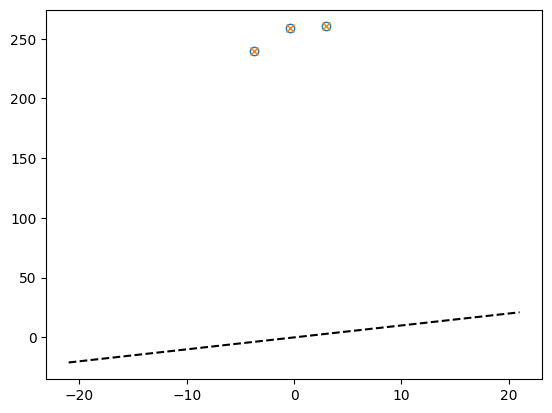

In [ ]:
t0 = 670.7
theta = -0.08*np.pi
x0 = 0.03*width
c = lat2coef('LLRL')
x_obvs = xn + c*v*(dt-t0)
x_expc = x0 + z*np.tan(theta)
not_na = np.where(~np.isnan(c))[0]

z_arr = np.zeros((4,not_na.size))
z_arr[0] = z [not_na]
z_arr[1] = c [not_na]
z_arr[2] = xn[not_na]
z_arr[3] = v

plt.plot(
    xn + c*v*(h2dt(z,c,xn,theta,x0,t0,v)-t0),
    x_obvs,
    linestyle='none',
    marker = 'o',
    label='fitted',
    mfc='none',
)
plt.plot(
    xn + c*v*(h2dt_zcxnv(z_arr,theta,x0,t0)-t0),
    x_obvs,
    linestyle='none',
    marker = 'x',
    label='fitted'
)
plt.plot((-21,21),(-21,21),'k',zorder=-1,linestyle='dashed')
plt.show()